<img src="https://m.files.bbci.co.uk/modules/bbc-morph-news-waf-page-meta/2.5.2/bbc_news_logo.png"/>

# BBC Article topic and theme identification
***

The target of this program is to identify the G20 countries discussed about in each article. This may be directly talking about the country or indirect references. For example, if the article mentions White House, we should identify that the article is referencing USA. 

The next step is to further identify and group the articles into themes.

### Useful information

The G20 is made up of 19 countries and the European Union. The 19 countries are Argentina, Australia, Brazil, Canada, China, Germany, France, India, Indonesia, Italy, Japan, Mexico, the Russian Federation, Saudi Arabia, South Africa, South Korea, Turkey, the UK and the US.

# Table of Content
***
### Getting started:
- Define the objective

- Import necessary packages

- Read in the necessary data

### Text Processing:

- Normalizing Words (Removing punctuation, stop words)

### Extraction information from Text:

- Extracting entities using Spacy

- Capturing direct references of G20 conutries

- Capturing indirect references using DBPedia

- Consolidating the information

### Topic Modeling

- Vectorize the data (TF-IDF)

- LDA model exploration to find best fit

- NMF model 

- Inference of top n categories



## Importing Relavant Packages

In [1]:
# General Packages
import numpy as np
import pandas as pd
import re
import itertools
from matplotlib import pyplot as plt
import wikipedia
from bs4 import BeautifulSoup
import requests

# NLP packages
from nltk.corpus import stopwords
import spacy
import en_core_web_sm
nlp = en_core_web_sm.load()
from nltk.tokenize import word_tokenize
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy import displacy

# Model building packages
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm, tqdm_notebook
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import Normalizer
from scipy.sparse import hstack

# LDA modules
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
import gensim
import gensim.corpora as corpora
from gensim import matutils
from gensim.models import CoherenceModel

unable to import 'smart_open.gcs', disabling that module


## Read in the datafiles

In [2]:
n = 0
business={}
while True:
    try:
        n=n+1
        file = open('business/'+str(n).zfill(3)+'.txt', "r")
        business[n] = file.read()
    except: break
       

### Check the data and it's type

In [3]:
print(business[10])

Court rejects $280bn tobacco case

A US government claim accusing the country's biggest tobacco companies of covering up the effects of smoking has been thrown out by an appeal court.

The demand for $280bn (Â£155bn) - filed by the Clinton administration in 1999 - was rejected in a 2-1 decision. The court in Washington found that the case could not be brought under federal anti-racketeering laws. Among the accused were Altria Group, RJ Reynolds Tobacco, Lorillard Tobacco, Liggett Group and Brown and Williamson. In its case, the government claimed tobacco firms manipulated nicotine levels to increase addiction, targeted teenagers with multi-billion dollar advertising campaigns, lied about the dangers of smoking and ignored research to the contrary.

Prosecutors wanted the cigarette firms to surrender $280bn in profits accumulated over the past 50 years and impose tougher rules on marketing their products. But the Court of Appeals for the District of Columbia ruled that the US government

### Store the data in a DataFrame for easier manipulation

In [4]:
article_df = pd.DataFrame.from_dict(business, orient = 'index', columns=['article'])
article_df.head(5)

,article
1,Ad sales boost Time Warner profit\n\nQuarterly...
2,Dollar gains on Greenspan speech\n\nThe dollar...
3,Yukos unit buyer faces loan claim\n\nThe owner...
4,High fuel prices hit BA's profits\n\nBritish A...
5,Pernod takeover talk lifts Domecq\n\nShares in...


# Text Preprocessing
## Cleaning

In [5]:
# Removing any special characters and keep only letters and numbers
article_df["article"] = article_df["article"].apply(lambda x: re.sub("[^a-zA-Z]+"," ",x))

In [6]:
# Remove any stopwords
nltk.download('stopwords')
stop = stopwords.words('english')
stop.extend(['said', 'The', 'Mr', 'also', 'year', 'But', 'It', 'In', 'bn', 'mn', 'last', 'would', \
             'could', 'mr', 'A', 'say', 'many', 'They', 'Those', 'That', 'Ask', 'Its'])

# The usual method to remove stopwords would be to make them all smaller but in our case, 
# we cannot do that. This is because converting to lowercase would make 'US' as 'us' which
# are obviously two different words.

def remove_stop(x:pd.Series)-> str:
    '''
    Takes in a Series object and returns a string with necessary modifications done
    '''
    article = x['article']
    tokens = word_tokenize(article)
    rx = re.compile('\w{2,}')
    tokens_without_sw= [word for word in tokens if word not in stop and rx.match(word)]

    return (" ".join(tokens_without_sw))

article_df["article"] = article_df.apply(remove_stop, axis=1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ramya\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
article_df["article"][11]

'Jeeves tips online ad revival Jeeves become third leading online search firm week thank revival internet advertising improving fortunes firm revenue nearly tripled fourth quarter exceeding Jeeves among best known names web relatively modest player profit quarter dwarfed announced rival Google earlier week During quarter Yahoo earned tipping resurgence online advertising trend taken hold relatively quickly Late marketing company Doubleclick one leading providers online advertising warned business put sale Thursday announced sharp turnaround brought unexpected increase profits Neither Jeeves Doubleclick thrilled investors profit news however cases shares fell Analysts attributed falls excessive expectations quarters fuelled dramatic outperformance Google Tuesday'

## Extracting Information from Text

### Listing G20 Countries

In [8]:
# All the roots of the G19 countries
g19_countries_root = ["Argenti", "Aussie", "Australia", "Brazil", "Canad", "Chin", "German", \
     "France", "French", "India", "Indonesia", "Japan", "Mexic", "Russia", "Arabia", "Ital",\
     "South Africa", "Korea", "Turk", "US", "United States", "America"]

# All the roots and European countries
european_union_root = ['Austria', 'Belgi', 'Latvia', 'Bulgaria','Lithuania', 'Croatia', 'Luxembourg',\
'Cyprus', 'Malta', 'Czechia', 'Netherland', 'Dutch' 'Denmark', 'Pol', 'Estonia', 'Portug',\
'Fin', 'Romania', 'French', 'France', 'Slovakia', 'Slovenia', 'Gree', 'Spanish', 'Spain', 'Hungar', 'Swed']

# All the roots of United Kingdom countries
uk=["UK", "United Kingdom", "England", "Scottish", "Scotland", "Wales", "Ireland", "Irish"]

# Matching the root words with the countries
matching_dict={"Chin":"China", "Arabia":'Saudi Arabia', "Argenti":"Argentina", 'Hungar': 'Hungary',\
                  'Swed': 'Sweden', "Aussie":"Australia", "Canad":"Canada", "Mexic":"Mexico", \
                  "French": 'France', "America":"US", "Turk":"Turkey", "German":"Germany","Ital":"Italy",\
                  "United States":"US", "uk":"UK"}

### Extracting Entities

We use the Spacy NLP package to extract the entities. We will use the Spacy display package to visualize this. Looking at this example articles, we might want to capture all entities of type 'ORG', 'NORP' and 'GPE'. 

In [9]:
displacy.render(nlp(article_df.loc[10][0]), jupyter=True, style='ent')

In [10]:
def get_entities(article:str)->list:
    '''
    Takes in a string type and return a list of required entities
    '''
    entities = [ent.text for ent in nlp(article).ents if ent.label_ in ['GPE', 'ORG', 'NORP']]
    return list(set(entities))
    
get_entities(article_df.loc[10][0])

['Court Appeals District Columbia', 'US', 'Washington', 'Mafia']

In [11]:
article_df["entities"] = article_df["article"].apply(get_entities)

### Filter out any direct references of the G20 countries and remove them from entities

In [12]:
def extract_g20_names(text_summary:str)->set:
    '''
    Takes in a string and returns a set of mentions of G20 countries
    '''
    country_set = set()

    # Add country name if country in G19
    for country in g19_countries_root:
        if country in text_summary:
            country_set.add(country)
            
    # Add EU for any European country
    for country in european_union_root:
        if country in text_summary:
            country_set.add('EU')
    
    # Add UK for any united kingdom country
    for country in uk:
        if country in text_summary:
            country_set.add('UK')
            
    return list(country_set)

def direct_reference(x: pd.Series)->list:
    '''
    Takes in a series object and returns list of direct mentions of G20 countries
    '''
    
    entities = x['entities'] 
          
    # Get any direct mentions of G20 countries in the article
    country_set = extract_g20_names(x['article'])
    
    # Remove the entities with country names
    for country in country_set:
        for entity in entities:
            if country in entity:
                entities.remove(entity)
                
    x['entities'] = entities
    return list(country_set)

article_df['direct_reference'] = article_df.apply(direct_reference, axis=1)

In [13]:
article_df.head()

,article,entities,direct_reference
1,Ad sales boost Time Warner profit Quarterly pr...,"[TimeWarner, SEC, Bertelsmann, Time Warner, AO...","[US, German]"
2,Dollar gains Greenspan speech dollar hit highe...,"[Federal Reserve, Friday Federal Reserve, Whit...","[EU, America, Chin, US]"
3,Yukos unit buyer faces loan claim owners embat...,"[Reuters, Yukos, State, Legal, Rosneft, Moscow...","[Russia, US]"
4,High fuel prices hit BA profits British Airway...,"[Dresdner Kleinwort Wasserstein, BA, Club Worl...",[United States]
5,Pernod takeover talk lifts Domecq Shares UK dr...,"[Glenmorangie, Paris, Scotland, GMT, Stolichna...","[EU, French, France, US, UK]"


### Using DBPedia descriptions for indirect references of a country

In [14]:
def get_info(query_string:str, API='KeywordSearch')-> str:
    '''
    Takes in the query string and uses the API specified to perform required action and send out the description.
    '''
    
    # The default DBPedia URL
    dbpedia_url = 'http://lookup.dbpedia.org/api/search.asmx/'
    api_url = dbpedia_url + API 
    params = {}
    if not params:
        params['QueryString'] = query_string
    
    # Get the content of the required url
    response = requests.get(api_url, params=params)
    soup = BeautifulSoup(response.content, 'xml')
    
    # Extract the most relevant (first result) link summary
    link = soup.find('Description')

    # If there is no relevant information return 'None'
    if link is not None:
        return link.text
    return 'None'

In [15]:
def get_referred_countries(x:pd.Series)-> list:
    '''
    Takes in a series object, searches dbpedia page for each entity
    Searches the summaries for mentions of G20 countries and returns a list of these mentions
    '''
    entities = x['entities']
    country_set = set()
    
    for entity in entities:
        summary = get_info(entity)[:250]
        country_set.update(extract_g20_names(summary))
    
    return list(country_set)

Consider the following article for example:

In [16]:
article_df.loc[19]['article']

'India widens access telecoms India raised limit foreign direct investment telecoms companies Communications Minister Dayanidhi Maran need fund fast growing mobile market government hopes increase number mobile users million million We need least investment part come foreign direct investment Maran decision raise limit foreign investors faced considerable opposition communist parties give crucial support coalition headed Prime Minister Manmohan Singh Potential foreign investors however need government approval increase stake beyond Maran Key positions chief executive chief technology officer chief financial officer held Indians added Analysts investors welcomed government decision positive development carriers investment community looking take longer term view huge growth Indian telecoms market Gartner principal analyst Kobita Desai FDI relaxation coupled rapid local market growth really ignite interest Indian telecommunication industry added Ernst Young Sanjay Mehta Investment bank Mo

In [17]:
article_df.loc[19]

article             India widens access telecoms India raised limi...
entities            [Hutchison Whampoa Sterling, Maran, Singapore ...
direct_reference                                              [India]
Name: 19, dtype: object

In [18]:
def get_all_mentions(x:pd.Series)-> list:
    
    direct_countries = x['direct_reference']
    referred_countries = get_referred_countries(x)
    
    all_mentioned_countries = set(direct_countries+referred_countries)
    
    return list(all_mentioned_countries)

In [19]:
get_all_mentions(article_df.loc[19])

['EU', 'India', 'Chin', 'French', 'United States']

In [20]:
article_df['all_mentioned_countries'] = article_df.apply(get_all_mentions, axis=1)

In [21]:
article_df.head()

,article,entities,direct_reference,all_mentioned_countries
1,Ad sales boost Time Warner profit Quarterly pr...,"[TimeWarner, SEC, Bertelsmann, Time Warner, AO...","[US, German]","[America, US, United States, German]"
2,Dollar gains Greenspan speech dollar hit highe...,"[Federal Reserve, Friday Federal Reserve, Whit...","[EU, America, Chin, US]","[EU, America, Chin, United States, US, UK]"
3,Yukos unit buyer faces loan claim owners embat...,"[Reuters, Yukos, State, Legal, Rosneft, Moscow...","[Russia, US]","[Russia, US, United States, UK]"
4,High fuel prices hit BA profits British Airway...,"[Dresdner Kleinwort Wasserstein, BA, Club Worl...",[United States],"[EU, France, United States, UK]"
5,Pernod takeover talk lifts Domecq Shares UK dr...,"[Glenmorangie, Paris, Scotland, GMT, Stolichna...","[EU, French, France, US, UK]","[EU, Russia, America, French, United States, C..."


In [22]:
article_df1 = article_df.copy()

### Keep only the relevant columns

In [23]:
article_df = article_df[["article","all_mentioned_countries"]]

In [24]:
article_df.head()

,article,all_mentioned_countries
1,Ad sales boost Time Warner profit Quarterly pr...,"[America, US, United States, German]"
2,Dollar gains Greenspan speech dollar hit highe...,"[EU, America, Chin, United States, US, UK]"
3,Yukos unit buyer faces loan claim owners embat...,"[Russia, US, United States, UK]"
4,High fuel prices hit BA profits British Airway...,"[EU, France, United States, UK]"
5,Pernod takeover talk lifts Domecq Shares UK dr...,"[EU, Russia, America, French, United States, C..."


In [25]:
# Remove repeated United States mentions and replace Chin with Chinese
article_df.all_mentioned_countries[2]

['EU', 'America', 'Chin', 'United States', 'US', 'UK']

## Consolidate the information
### Removing duplicates and substitute roots with countries

In [26]:
def consolidate(x):
   
    all_mentioned_countries = x['all_mentioned_countries']
   
    for country in all_mentioned_countries:  
        if country in matching_dict.keys():
            all_mentioned_countries.remove(country)
            all_mentioned_countries.append(matching_dict[country])

    return list(set(all_mentioned_countries))


In [27]:
consolidate(article_df.loc[2])

['EU', 'Chin', 'US', 'UK']

In [28]:
article_df["all_mentioned_countries"] = article_df.apply(consolidate, axis=1)

In [29]:
article_df.loc[5]

article                    Pernod takeover talk lifts Domecq Shares UK dr...
all_mentioned_countries          [EU, Russia, French, Canad, France, US, UK]
Name: 5, dtype: object

### Segregate the countries

In [30]:
article_df['all_mentioned_countries'].str.len().value_counts()

2    107
3     93
1     85
4     83
5     62
6     37
7     22
8     10
9      7
0      4
Name: all_mentioned_countries, dtype: int64

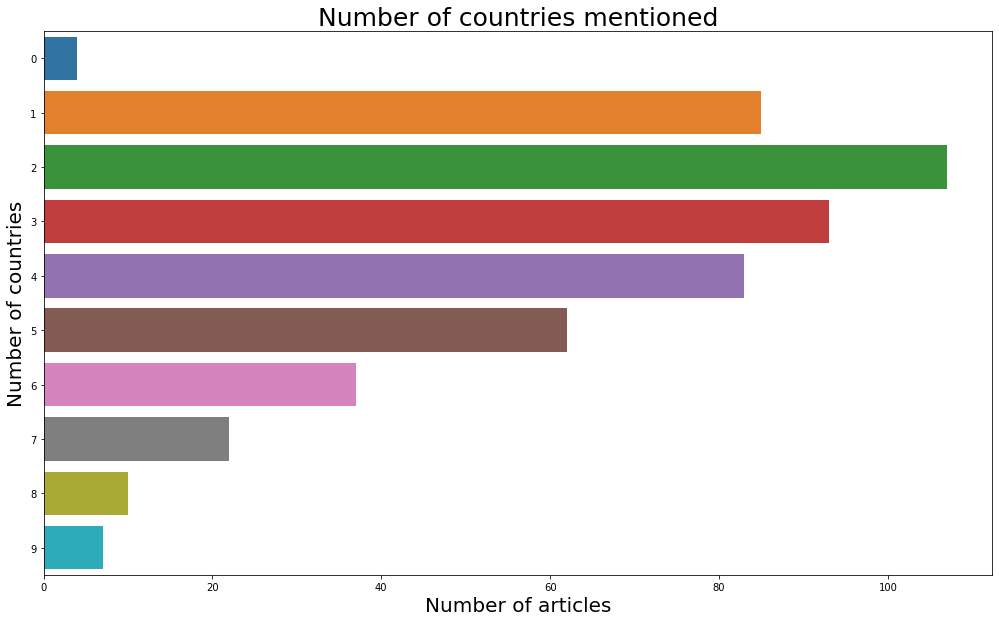

In [31]:
import seaborn as sns
plt.figure(figsize=(17,10))
sns.countplot(y = article_df['all_mentioned_countries'].str.len(), orient = 'v')
plt.title('Number of countries mentioned', fontsize = 25)
plt.ylabel('Number of countries', fontsize = 20)
plt.xlabel('Number of articles', fontsize = 20)
plt.show()

In [32]:
article_df['num_countries'] = article_df["all_mentioned_countries"].str.len()
extracted_df = pd.get_dummies(article_df.all_mentioned_countries.apply(pd.Series).stack()).sum(level=0)

In [33]:
extracted_df.head()

,America,Arabia,Argenti,Argentina,Australia,Brazil,Canad,Canada,Chin,China,...,Korea,Mexic,Mexico,Russia,Saudi Arabia,South Africa,Turkey,UK,US,United States
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
5,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,1,0


In [34]:
extracted_df.sum(axis = 0, skipna = True).sort_values(ascending=False)

US               362
EU               258
UK               228
France           105
India             81
United States     76
Germany           68
Japan             63
China             59
Russia            56
German            39
Australia         36
Chin              31
French            29
Canad             27
Brazil            26
Korea             24
Italy             24
Canada            23
South Africa      23
Saudi Arabia      22
Indonesia         17
Ital              16
Turkey            12
Mexico             9
Mexic              7
Argentina          5
Argenti            5
Arabia             5
America            3
dtype: int64

In [35]:
feature_df = pd.concat([article_df.drop('all_mentioned_countries', axis=1), \
                        pd.get_dummies(article_df.all_mentioned_countries.apply(pd.Series).stack()).sum(level=0)],axis=1)
feature_df.fillna(0, inplace=True)

# Topic Modeling

There are different ways generally used for theme extraction. The most popular methods being k-means clustering, LDA (Latent Dirichlet Allocation) and Non-negative Matrix Factorization (NMF). 

#### K-Means clustering
The k-means method works by assuming an number of clusters and it tries to segregate the data according to the Euclidean distance metric. For data such as this, the initialization of clusters might play a very important role. So, we run this several times with different starting points to fix a cluster centroid. Once the cluster centroids are fixed, we take the closest centroid to classify an article. 

#### LDA
LDA on the other hand assumes that each article is a mixture of different topics and tries to find the importance of words that attributes them to different clusters. We can then assume the document to be assigned to a cluster with maximium probability or decide it to be a combination of two topics by defining a threshold. 

#### NMF
NMF (Non-negative Matrix Factorization) tries to factorize the vectorized into product of two matrices. One matrix is like the Basis matrix which is like forming different features(topics) for the dataset and the other matrix is the components which stands for the feature importance.

**We will be using LDA for clustering**

Before we start any model building, we need to convert our text data into numerical data.

## Vectorization

### TFIDF
**TF** Term Frequency proportional to the number of times a term appears on the instance.

**IDF** Inverse Document Frequency inversely proportional to the number of times a text appears throughout the corpus.

We essentially multiply both the above terms to assign a value to a word.

In [36]:
vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words=stop)
vectorized_df = vectorizer.fit_transform(feature_df['article'])

print("Article Matrix Shape: " + str(vectorized_df.shape))

Article Matrix Shape: (510, 3449)


#### TFIDF Weights value check

Considering that the matrix is only 3573 columns, we need not try to reduce the number of columns explicitly.
Let's check the highest weighted and lowest weighted words.

In [37]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))

sorted(tfidf.items(), key=lambda s: s[1], reverse=True)[:20]

[('accounting scandal', 5.44461012097565),
 ('aceh', 5.44461012097565),
 ('achieve', 5.44461012097565),
 ('across europe', 5.44461012097565),
 ('actively', 5.44461012097565),
 ('added however', 5.44461012097565),
 ('address', 5.44461012097565),
 ('affect', 5.44461012097565),
 ('afford', 5.44461012097565),
 ('afghanistan', 5.44461012097565),
 ('ahead meeting', 5.44461012097565),
 ('airline industry', 5.44461012097565),
 ('al', 5.44461012097565),
 ('allege', 5.44461012097565),
 ('alleging', 5.44461012097565),
 ('ambitious', 5.44461012097565),
 ('amounts', 5.44461012097565),
 ('anglo', 5.44461012097565),
 ('angry', 5.44461012097565),
 ('ap', 5.44461012097565)]

In [38]:
# These are the most common words across the document as well as each article.
# Hence these values are weighed down.
sorted(tfidf.items(), key=lambda s: s[1])[:20]

[('us', 1.6416582106018653),
 ('new', 1.8114195727223017),
 ('market', 1.856472236663245),
 ('company', 1.879783315531692),
 ('however', 1.9182495963594879),
 ('firm', 1.9840961621570745),
 ('two', 2.0214338325947185),
 ('one', 2.0489837843629495),
 ('years', 2.0489837843629495),
 ('chief', 2.0715836162801904),
 ('growth', 2.0888751133902517),
 ('expected', 2.161195774969878),
 ('may', 2.167465387983473),
 ('government', 2.1801237848553963),
 ('world', 2.205931668811269),
 ('analysts', 2.212489069357428),
 ('since', 2.212489069357428),
 ('economy', 2.25963584778313),
 ('business', 2.287609699825536),
 ('economic', 2.3091159050464998)]

## LDA Model Exploration

In [39]:
# Making a pipeline
def feature_extraction_1(data):
    
    vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words=stop)
    X_article = vectorizer.fit_transform(feature_df['article'])
    X_countries = feature_df.loc[:, feature_df.columns != 'article']
    
    return hstack((X_article, X_countries)).tocsr()

#### Create a corpus and dictionary

Tokenize the data

In [40]:
def tokenize(x:pd.Series)->list:
    '''
    Takes in a series object and returns tokens of the text
    '''
    text = x['article']
    
    # Tokenize the text
    text = word_tokenize(text)
    
    return text

In [41]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

feature_df = article_df.copy()
feature_df['tokens'] = feature_df.apply(tokenize, axis=1)
bigram = gensim.models.Phrases(feature_df['tokens'], min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
feature_df['tokens_bigram'] = feature_df['tokens'].progress_map(lambda tokens: bigram_mod[tokens])

id2word = corpora.Dictionary(feature_df['tokens_bigram'])
texts = feature_df['tokens_bigram'].values
corpus = [id2word.doc2bow(text) for text in texts]

progress-bar: 100%|█████████████████████████████████████████████████████████████████| 510/510 [00:00<00:00, 535.71it/s]


In [42]:
# Define the LDA model
def LDA_model(num_topics, passes=1):
    return gensim.models.ldamodel.LdaModel(corpus=tqdm_notebook(corpus, leave=False), id2word=id2word,
                                               num_topics=num_topics, eval_every=10, chunksize=2000,
                                               passes=passes, per_word_topics=True)

In [43]:
# Metrics for evaluating model
def compute_coherence(model):
    coherence = CoherenceModel(model=model, texts=feature_df['tokens_bigram'].values,
                           dictionary=id2word, coherence='c_v')
    return coherence.get_coherence()

In [44]:
# Display the topics and associated keywords
def display_topics(model):
    topics = model.show_topics(num_topics=model.num_topics, formatted=False, num_words=15)
    topics = map(lambda c: map(lambda cc: cc[0], c[1]), topics)
    df = pd.DataFrame(topics)
    df.index = ['Topic {0}'.format(i+1) for i in range(model.num_topics)]
    df.columns = ['Keyword {0}'.format(i) for i in range(1, 16)]
    return df

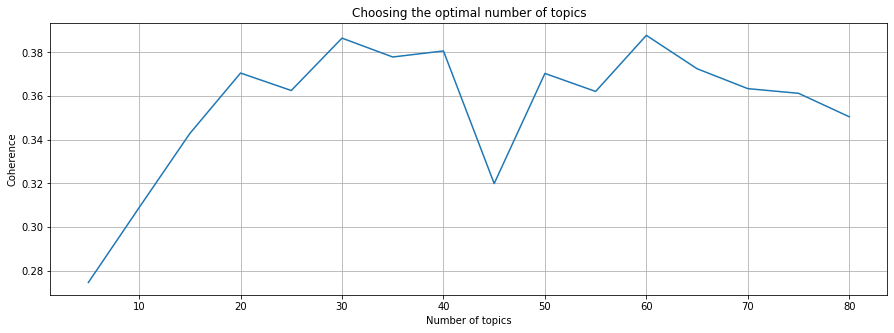

In [45]:
# Finding out the hyperparameters of the model (number of topics)
def explore_models(df, rg=range(5, 25)):
    id2word = corpora.Dictionary(df['tokens_bigram'])
    texts = df['tokens_bigram'].values
    corpus = [id2word.doc2bow(text) for text in texts]

    models = []
    coherences = []
    
    for num_topics in tqdm_notebook(rg, leave=False):
        lda_model = LDA_model(num_topics, passes=5)
        models.append(lda_model)
        coherence = compute_coherence(lda_model)
        coherences.append(coherence)
      
    fig = plt.figure(figsize=(15, 5))
    plt.title('Choosing the optimal number of topics')
    plt.xlabel('Number of topics')
    plt.ylabel('Coherence')
    plt.grid(True)
    plt.plot(rg, coherences)
    
    return coherences, models


coherences, models = explore_models(feature_df, rg=range(5, 85, 5))

Depending on this graph, the number of clusters might be around 20. We don't want to induce noise by choosing too many clusters. So, we will use small number of clusters even  if it means not capturing all of the clusters. So, let's choose n = 10 for simplicity sake.

In [46]:
best_model = LDA_model(num_topics=10, passes=5)

display_topics(model=best_model)

,Keyword 1,Keyword 2,Keyword 3,Keyword 4,Keyword 5,Keyword 6,Keyword 7,Keyword 8,Keyword 9,Keyword 10,Keyword 11,Keyword 12,Keyword 13,Keyword 14,Keyword 15
Topic 1,government,state,WMC,firm,new,company,China,people,UK,oil,projects,prices,age,years,price
Topic 2,US,economic,economy,growth,countries,oil,government,prices,people,market,world,two,Deutsche_Boerse,dollar,million
Topic 3,US,GM,economy,new,deal,sales,company,market,Fiat,tax,may,government,business,two,one
Topic 4,US,India,company,firm,dollar,oil,one,new,MCI,government,Indian,market,companies,shares,foreign
Topic 5,growth,firm,economy,UK,rise,US,company,market,shares,economic,annual,years,euros,quarter,expected
Topic 6,US,China,firms,growth,dollar,economy,prices,profits,government,rise,rate,sales,market,euros,expected
Topic 7,Glazer,club,US,China,offer,new,bid,company,Turkey,board,United,debt,two,Manchester_United,However
Topic 8,sales,firm,company,US,new,Yukos,deal,market,December,government,business,years,profits,profit,court
Topic 9,US,sales,market,growth,new,figures,profits,rose,world,UK,price,years,one,jobs,companies
Topic 10,Yukos,US,company,firm,Gazprom,court,Russian,sale,Ebbers,oil,government,Yugansk,fraud,Rosneft,Russia


Frankly, the results are quite disappointing. There doesn't seem to be a clear distinction between them.

## NMF Model

In [47]:
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(min_df=5, analyzer='word', ngram_range=(1, 2), stop_words=stop)
vz = vectorizer.fit_transform(list(feature_df['tokens'].map(lambda tokens: ' '.join(tokens))))

nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(vz)

feature_names = vectorizer.get_feature_names()
no_top_words = 10
word_dict = {}

for topic_idx, topic in enumerate(nmf.components_[:10]):
    word_dict["Topic %d:"% (topic_idx)] = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]

pd.DataFrame.from_dict(word_dict, orient='index')

,0,1,2,3,4,5,6,7,8,9
Topic 0:,economy,growth,rates,rate,figures,economic,bank,consumer,interest,quarter
Topic 1:,yukos,russian,gazprom,yugansk,rosneft,court,russia,oil,auction,khodorkovsky
Topic 2:,company,shares,firm,sales,us,market,profits,india,new,china
Topic 3:,lse,boerse,deutsche boerse,deutsche,euronext,bid,london,offer,exchange,stock
Topic 4:,budget,deficit,bush,spending,congress,president,budget deficit,tax,military,administration
Topic 5:,ebbers,worldcom,sullivan,fraud,mci,accounting,former,trial,witness,guilty
Topic 6:,dollar,euro,us,currency,deficit,trade,yen,trading,exports,record
Topic 7:,oil,crude,prices,barrel,opec,oil prices,us crude,winter,weather,us
Topic 8:,glazer,club,united,manchester,manchester united,bid,board,proposal,magnier,mcmanus
Topic 9:,fiat,gm,car,general motors,engines,motors,auto,italian,stake,sell


The results from NMF seem to be much better than LDA model. We can clearly see the distinction between the topics. 

### 10 probable categories

Topic-1
Economic growth

Topic-2
Russia's Oil Production

Topic-3
Overall economic scenario and earning reports

Topic-4
Automotive industry 

Topic-5
Economy of South Asian countries 

Topic-6
US stock market and news

Topic-7
European stock market and news

Topic-8
India, US and China relations and economy

Topic-9
US economy

Topic-10
Germantrade and economy